<a href="https://colab.research.google.com/github/Zoeb137/Credit-Risk-Modeling/blob/main/Home_Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuration**

安装kaggle api

In [ ]:
!pip install kaggle

从kaggle账户中新建token获得kaggle.json文件，并运行以下代码上传

In [ ]:
from google.colab import files
uploaded = files.upload()

# Make sure the kaggle.json file is in the current directory
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


将kaggle.json放到正确的位置

In [ ]:
import os

# Ensure .kaggle directory exists at the correct path
os.makedirs('/root/.kaggle', exist_ok=True)  # Fixed directory path

# Move the kaggle.json into this directory
!mv kaggle.json /root/.kaggle/  # Corrected command

# Set the correct permissions for the file
!chmod 600 /root/.kaggle/kaggle.json  # Corrected command



下载项目数据

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

100% 3.10G/3.10G [01:53<00:00, 32.5MB/s]
100% 3.10G/3.10G [01:53<00:00, 29.4MB/s]


解压项目数据

In [ ]:
!unzip /content/home-credit-credit-risk-model-stability.zip -d /content/home-credit-data

Archive:  /content/home-credit-credit-risk-model-stability.zip
  inflating: /content/home-credit-data/csv_files/test/test_applprev_1_0.csv  
  inflating: /content/home-credit-data/csv_files/test/test_applprev_1_1.csv  
  inflating: /content/home-credit-data/csv_files/test/test_applprev_1_2.csv  
  inflating: /content/home-credit-data/csv_files/test/test_applprev_2.csv  
  inflating: /content/home-credit-data/csv_files/test/test_base.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_1_0.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_1_1.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_1_2.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_1_3.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_1_4.csv  
  inflating: /content/home-credit-data/csv_files/test/test_credit_bureau_a_2_0.csv  
  inflating: /content/home-credit-data/csv_file

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

def load_and_process_csv(file_path, chunk_size=50000):
    """
    Loads a CSV file in chunks and processes each chunk.

    Args:
    - file_path: The path to the CSV file to read.
    - chunk_size: The number of rows per chunk. Default is 50000.

    Returns:
    - df_concatenated: A DataFrame containing all the processed chunks.
    """
    chunks = []  # List to hold the processed chunks

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Process each chunk here
        # For now, we're just collecting the chunks directly
        chunks.append(chunk)

    # Concatenate all chunks into a single DataFrame
    df_concatenated = pd.concat(chunks, axis=0)

    return df_concatenated


In [ ]:
df_feature_definition = load_and_process_csv('/content/home-credit-data/feature_definitions.csv')
des_dict = df_feature_definition.set_index('Variable')['Description'].to_dict()

In [ ]:
def batch_descriptions(df, desc_dict, batch_size=5):
    """
    一个生成器函数，用于分批遍历DataFrame的列（变量）并获取它们的描述。

    参数:
    - df: 包含数据的pandas DataFrame。
    - desc_dict: 一个字典，包含变量名称到描述的映射。
    - batch_size: 每批处理的变量数量。

    产出:
    - 每次迭代产生一个包含列名和其描述的批次(list of tuples)。
    """
    for i in range(0, len(df.columns), batch_size):
        batch_columns = df.columns[i:i+batch_size]
        batch_descriptions = [(column, desc_dict.get(column, 'not found')) for column in batch_columns]
        yield batch_descriptions


In [ ]:
def format_output(iterator_output,index):
    formatted_output = []  # 用于存储格式化后的字符串
    for item in iterator_output:
        key, description = item  # 分解每个元组为key和description
        formatted_output.append(f"## {index}. {key}\n{description}")  # 按新格式添加到列表
        index+=1
    return "\n".join(formatted_output)  # 将列表转换为单个字符串

1. **Business Analysis**
A deep understanding of the business context and goals is a crucial first step. Through business analysis, you can identify key factors that may affect default rates. At this stage, working with domain experts to understand what factors may affect the default risk of a loan can help you be more targeted in subsequent data analysis.
2. **Find relevant attributes**
Filtering relevant attributes based on business understanding (feature selection) is an important step to improve model efficiency and performance. This can be achieved through statistical testing, feature importance scoring, etc. Note that some seemingly irrelevant attributes may also be converted into useful signals through feature engineering.
3. **Data analysis**
It is very important to conduct thorough exploratory data analysis (EDA) on the data before modeling, including data distribution, missing value processing, outlier checking, etc. This step helps discover patterns, anomalies, structural issues, etc. in the data and lays the foundation for subsequent model development.
4. **Build an initial model**
Starting with simple models can help you get baseline results quickly, such as logistic regression, decision trees, etc. These models are generally easy to understand and interpret, and are computationally cheap.
5. **Validate and complicate the model**
Based on the initial model, gradually try more complex models and algorithms, such as random forest, gradient boosting machine (GBM), neural network, etc., to improve prediction performance. At the same time, use techniques such as cross-validation to evaluate the generalization ability of the model and avoid overfitting.
6. **Model tuning and evaluation**
Further improve model performance through parameter tuning. This can be done manually or using automated methods such as Grid Search or Random Search. Make sure to choose appropriate evaluation metrics (such as AUC, precision, recall, etc.) to measure the performance of the model.
7. **Interpret the model and results**
Especially in the financial field, model interpretability is very important. Use appropriate tools and techniques (such as feature importance, SHAP values, etc.) to explain the model's prediction and decision-making process.

#  **Base**

## **Analysis**
The test set needs to adopt stratified sampling based on weeknum to ensure that the auc and gini coefficients can be calculated based on week.


In [ ]:
df_base = load_and_process_csv('/content/home-credit-data/csv_files/train/train_base.csv')

In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   case_id        1526659 non-null  int64 
 1   date_decision  1526659 non-null  object
 2   MONTH          1526659 non-null  int64 
 3   WEEK_NUM       1526659 non-null  int64 
 4   target         1526659 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 58.2+ MB


In [ ]:
df_base.describe()

,case_id,MONTH,WEEK_NUM,target
count,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06
mean,1.286077e+06,2.019363e+05,4.076904e+01,3.143728e-02
std,7.189466e+05,4.473597e+01,2.379798e+01,1.744964e-01
min,0.000000e+00,2.019010e+05,0.000000e+00,0.000000e+00
25%,7.661975e+05,2.019060e+05,2.300000e+01,0.000000e+00
50%,1.357358e+06,2.019100e+05,4.000000e+01,0.000000e+00
75%,1.739022e+06,2.020010e+05,5.500000e+01,0.000000e+00
max,2.703454e+06,2.020100e+05,9.100000e+01,1.000000e+00


# Traditional Credit Risk Model :

the expected loss is calculated as follows:


**EL = PD × LGD × EAD = PD × (1 − RR) × EAD,**


here :
PD = probability of default
LGD = loss given default
EAD = exposure at default
RR = recovery rate (RR = 1 − LGD).
Expected loss is covered by revenues (interest rate, fees) and by loan loss provisions (based on the level of expected impairment).
The expected loss corresponds to the mean value of the credit loss distribution. Hence, it is only an average value which can be easily exceeded. Therefore, we define the unexpected loss as difference between a high quantile (i.e. 99 %) and the expected loss. Banks should hold enough capital in order to fully cover the unexpected loss.
When modelling credit risk losses, several important issues should be taken into account:
• Defaults are relatively rare events compared to market losses. The lack of available data is an issue for both calibrating the models as well as backtesting.
• Correlations between failures have a significant impact on the final result. They should not be underestimated.
• Wrong way exposure (growing utilization of credit cards in case of an increase in PD) should be taken into account.


# Reference for attribute defination

https://www.mdpi.com/2073-8994/13/1/83



# **static_0**

## **Bussiness analysis**

### **DPD Related Attributes**
These are critical as they directly relate to past payment behaviors, which are strong indicators of future default risks.

   - **1. actualdpdtolerance_344P**
   - **11. avgdbddpdlast24m_3658932P**
   - **12. avgdbddpdlast3m_4187120P**
   - **13. avgdbdtollast24m_4525197P**
   - **14. avgdpdtolclosure24_3658938P**
   - **17. avgmaxdpdlast9m_3716943P**
   - **91. maxdbddpdlast1m_3658939P**
   - **92. maxdbddpdtollast12m_3658940P**
   - **93. maxdbddpdtollast6m_4187119P**
   - **98. maxdpdlast12m_727P**
   - **99. maxdpdlast24m_143P**
   - **100. maxdpdlast3m_392P**
   - **101. maxdpdlast6m_474P**
   - **102. maxdpdlast9m_1059P**
   - **103. maxdpdtolerance_374P**

### **Payment Behavior and Instalment Patterns**
Attributes indicating regularity and timing of payments, which are significant for assessing financial discipline and stability.
   - **15. avginstallast24m_3658937A**
   - **19. avgpmtlast12m_4525200A**
   - **38. cntincpaycont9m_3716944L**
   - **39. cntpmts24_3658933L**
   - **117. numinstlallpaidearly3d_817L**
   - **120. numinstlswithdpd10_728L**
   - **121. numinstlswithdpd5_4187116L**
   - **122. numinstlswithoutdpd_562L**
   - **130. numinstpaidearly_338L**
   - **133. numinstpaidlate1d_3546852L**
   - **147. pctinstlsallpaidearl3d_427L**
   - **148. pctinstlsallpaidlat10d_839L**
   - **149. pctinstlsallpaidlate1d_3546856L**

### **Credit Utilization and Outstanding Balances**
Indicators of current financial obligations and credit utilization, reflecting on the borrower's debt burden.
   - **18. avgoutstandbalancel6m_4187114A**
   - **43. currdebt_22A**
   - **106. maxoutstandbalancel12m_4187113A**
   - **160. sumoutstandtotal_3546847A**
   - **162. totaldebt_9A**

### **Loan Application and Credit History**
Attributes related to the frequency of loan applications, which could indicate financial distress or credit shopping behavior.
   - **5. applicationcnt_361L**
   - **6. applications30d_658L**
   - **7. applicationscnt_1086L**
   - **142. numrejects9m_859L**

### **Income and Employment Stability**
Factors contributing to the borrower's ability to maintain consistent income, which is crucial for meeting loan obligations.
   - **22. clientscnt12m_3712952L**
   - **23. clientscnt3m_3712950L**
   - **24. clientscnt6m_3712949L**
   - **40. commnoinclast6m_3546845L**
   - **56. equalityempfrom_62L**
   - **86. maininc_215A**


In [ ]:
df_static_0_0 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_static_0_0.csv')

<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (45,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (20,45,57,84) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (45,57,84) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in p

In [ ]:
df_static_0_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


In [ ]:
df_static_0_0.describe()

,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,...,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A
count,1.003757e+06,707071.000000,574903.000000,1.003757e+06,1.003755e+06,1.003757e+06,1.003757e+06,1.003757e+06,1.003757e+06,1.003757e+06,...,939963.000000,911303.000000,869385.000000,1.003757e+06,1.003757e+06,6.879380e+05,2.953810e+05,1.003755e+06,1.003755e+06,138692.000000
mean,1.216924e+06,0.054391,50692.545111,3.875598e+03,1.348499e+03,2.689894e-05,1.261839e-01,4.200011e-01,1.238874e+00,3.163963e-01,...,0.007732,0.028932,33339.941490,1.537563e-01,1.449694e+00,2.646509e+04,2.606057e+04,1.818406e+04,7.927638e+04,10576.192565
std,6.964624e+05,8.743984,65457.938573,2.920237e+03,2.687341e+03,9.309873e-03,4.458153e-01,2.683453e+00,1.031643e+01,2.648092e+00,...,0.087592,0.167616,33206.102117,4.337781e-01,1.859990e+00,5.571921e+04,5.703931e+04,4.779889e+04,1.256841e+05,16354.417830
min,0.000000e+00,0.000000,0.000000,8.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-2.405000e+03,-2.405000e+03,0.000000e+00,0.000000e+00,0.222000
25%,7.259870e+05,0.000000,6452.900150,1.895800e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,13400.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3142.400100
50%,1.311700e+06,0.000000,26937.000000,3.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,24478.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.978000e+04,6008.500000
75%,1.562639e+06,0.000000,68960.840000,4.989800e+03,1.866600e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,43956.000000,0.000000e+00,2.000000e+00,2.718295e+04,2.570092e+04,1.196770e+04,1.018738e+05,11627.300250
max,2.651092e+06,3676.000000,992476.500000,1.060070e+05,8.562080e+04,5.000000e+00,2.500000e+01,4.430000e+02,2.470000e+02,7.700000e+01,...,1.000000,1.000000,761867.440000,8.000000e+00,3.300000e+01,1.210629e+06,1.085048e+06,1.210629e+06,7.988198e+06,794899.200000


In [ ]:
des_iterator_static_0_0 = batch_descriptions(df_static_0_0,des_dict,5)



## 0. case_id
## 1. actualdpdtolerance_344P
DPD of client with tolerance:
Days past due, it affects the standard of load default, a higher tolerance will reduce the default rate. In this problem, a penalty coefficient can be imposed for default cases with high tolerance.

## 2. amtinstpaidbefduel24m_4187115A
Number of instalments paid before due date in the last 24 months:
 A positive credit factor.

## 3. annuity_780A
Monthly annuity amount:Monthly repayment amount, considering whether the repayment amount will exceed the borrower's ability to pay

## 4. annuitynextmonth_57A

Next month's amount of annuity:The expected repayment amount due next month and the fixed interest rate should be the same as this month. But in some cases it will be different.Consider omitting this attribute or adding it to the calculation of the repayment amount.


## 5. applicationcnt_361L
Number of applications associated with the same email address as the client.The number of loan applications from users, taking into account fraud risk and credit risk.

## 6. applications30d_658L
Number of applications made by the client in the last 30 days.

## 7. applicationscnt_1086L
Number of applications associated with the same phone number.

## 8. applicationscnt_464L
Number of applications made in the last 30 days by other clients with the same employer as the applicant.

## 9. applicationscnt_629L
Number of applications with the same employer in the last 7 days.

## 10. applicationscnt_867L
Number of applications associated with the same mobile phone

Note : jointly calculate a risk factor


## 11. avgdbddpdlast24m_3658932P
Average days past or before due of payment during the last 24 months. Early Payments are negative values.

## 12. avgdbddpdlast3m_4187120P

Average days past or before due of payment during the last 3 months.

## 13. avgdbdtollast24m_4525197P

Average days of payment before due date within the last 24 months (with tolerance).

## 14. avgdpdtolclosure24_3658938P

Average DPD (days past due) with tolerance within the past 24 months from the maximum closure date, assuming that the contract is finished. If the contract is ongoing, the calculation is based on the current date.

Note: Joint computing to reduce dimensionality. Pay attention to what time changes may reveal



## 15. avginstallast24m_3658937A
Average instalments paid by the client over the past 24 months.The higher average monthly repayment amount may represent the customer's income level and repayment ability.

## 16. avglnamtstart24m_4525187A
Average loan amount in the last 24 months.The average amount of loans obtained by customers in the past two years.Reflects the size and nature of the loan.

Note:Joint computing.

## 17. avgmaxdpdlast9m_3716943P
Average Days Past Due (DPD) of the client in last 9 months.

## 18. avgoutstandbalancel6m_4187114A
Average outstanding balance of applicant for the last 6 months.Monthly average of remaining loan amount

## 19. avgpmtlast12m_4525200A

Average of payments made by the client in the last 12 months.




## 20. bankacctype_710L
Type of applicant's bank account.refers to the specific category or nature of the bank account held by the applicant for a loan or credit.

## 21. cardtype_51L
Type of credit card.

## 22. clientscnt12m_3712952L
Number of clients that have used the same mobile phone as the applicant in the past 12 months. risk factor

## 23. clientscnt3m_3712950L
Number of clients who have the same mobile phone number in the last 3 months.

## 24. clientscnt6m_3712949L
Total number of clients who have used the same mobile number in the last 6 months.


## 25. clientscnt_100L
Number of applications with matching employer's phone and client's.

## 26. clientscnt_1022L
Number of clients sharing the same mobile phone.

## 27. clientscnt_1071L
Number of applications where the alternative phone number matches that of the client.

## 28. clientscnt_1130L
Number of applications where client's phone number matches the alternative phone contact.

## 29. clientscnt_136L
Number of applications associated with same email address as client's email.

## 30. clientscnt_157L
Number of clients whose employer has the same phone number as the client.

## 31. clientscnt_257L
Number of clients that share an alternative phone number with the applicant.

## 32. clientscnt_304L
Number of clients with the same phone number.

## 33. clientscnt_360L
Number of clients that have the same alternative phone number and employer's phone number.

## 34. clientscnt_493L
Number of clients with matching phone numbers for both the employer and the client.

## 35. clientscnt_533L
Number of clients with same client's and alternative's phone number

## 36. clientscnt_887L
Number of clients sharing the same employer's phone number.

## 37. clientscnt_946L
Number of clients with matching mobile and employer's number.

Note:risk



## 38. cntincpaycont9m_3716944L
Number of incoming payments in the past 9 months. recent income stability positive factor

## 39. cntpmts24_3658933L
Number of months with any incoming payment in last 24 months.longtime income stability.positive factor

## 40. commnoinclast6m_3546845L
Number of communications indicating low income in the last six months Indicates recent low income. negative factor

## 41. credamount_770A
Loan amount or credit card limit.

## 42. credtype_322L
Type of credit

## 43. currdebt_22A
Current debt amount of the client.

## 44. currdebtcredtyperange_828A
Current amount of debt of the applicant.

Note:The client has already established contact, the applicant has not yet established contact. Different strategies for treating clients and applicants.Analyze the number of records for customer-related attributes. Maybe it can be ignored.



## 45. datefirstoffer_1144D
Date of first customer relationship management (CRM) offer. loyalty

## 46. datelastinstal40dpd_247D
Date of last instalment that was more than 40 days past due (DPD). Recent repayment behavior and financial stability

## 47. datelastunpaid_3546854D
Date of the last unpaid instalment. Financial difficulties that customers may face

## 48. daysoverduetolerancedd_3976961L
Number of days that past after the due date (with tolerance). negative factor

## 49. deferredmnthsnum_166L
Number of deferred months. negative factor

## 50. disbursedcredamount_1113A
Disbursed credit amount after consolidation.The impact needs to be analyzed

## 51. disbursementtype_67L
Type of disbursement. conjoint analysis

## 52. downpmt_116A
Amount of downpayment. positive factor

## 53. dtlastpmtallstes_4499206D
Date of last payment made by the applicant. Ignorable

## 54. eir_270L
Interest rate.

## 55. equalitydataagreement_891L
Flag indicating sudden changes in client's social-demographic data (e.g. education, family status, housing type).

## 56. equalityempfrom_62L
Flag indicating a sudden change in the client's length of employment. 0: Typically indicates no significant change in the client's length of employment, suggesting stable employment.

## 57. firstclxcampaign_1125D
Date of the client's first campaign. ignorable

## 58. firstdatedue_489D
Date of the first due date. ignorable

## 59. homephncnt_628L
Number of distinct home phones on client's application. risk

## 60. inittransactionamount_650A
Initial transaction amount of the credit application.

## 61. inittransactioncode_186L
Transaction type of the initial credit transaction.

## 62. interestrate_311L
The interest rate of the active credit contract. negative

## 63. interestrategrace_34L
Interest rate during the grace period.

## 64. isbidproduct_1095L
Flag indicating if the product is a cross-sell. Cross-selling involves offering additional, related, or complementary products to customers who already purchase or have purchased another product.

## 65. isbidproductrequest_292L
Flag indicating if the product is a cross-sell.

## 66. isdebitcard_729L
Flag indicating if the product is a debit card.





## 67. lastactivateddate_801D
Contract activation date for previous applications. ignorable

## 68. lastapplicationdate_877D
Date of previous customer's application.ignorable

## 69. lastapprcommoditycat_1041M
Commodity category of the last loan applications made by the applicant.

## 70. lastapprcommoditytypec_5251766M
Commodity type of the last application.

## 71. lastapprcredamount_781A
Credit amount from the client's last application.

## 72. lastapprdate_640D
Date of approval on client's most recent previous application.ignorable

## 73. lastcancelreason_561M
Cancellation reason of the last application.

## 74. lastdelinqdate_224D
Date of the last delinquency occurrence.

## 75. lastdependentsnum_448L
Number of dependents in the client's last loan application. Number of individuals who rely on the applicant for financial support

## 76. lastotherinc_902A
Amount of other income reported by the client in their last application.

## 77. lastotherlnsexpense_631A
Monthly expenses on other loans from the last application.

## 78. lastrejectcommoditycat_161M
Category of commodity in the applicant's last rejected application.

## 79. lastrejectcommodtypec_5251769M
Commodity type of the last rejected application.

## 80. lastrejectcredamount_222A
Credit amount on last rejected application.

## 81. lastrejectdate_50D
Date of most recent rejected application by the applicant.

## 82. lastrejectreason_759M
Reason for rejection on the most recent rejected application.

## 83. lastrejectreasonclient_4145040M
Reason for the client's last loan rejection.

## 84. lastrepayingdate_696D
Date of the last payment made by the applicant. ignorable

## 85. lastst_736L
Status of the client's previous credit application.

## 86. maininc_215A
Client's primary income amount.

## 87. mastercontrelectronic_519L
Flag indicating the existence of the master contract for the client.

## 88. mastercontrexist_109L
Flag indicating whether or not the applicant has an existing master contract.

## 89. maxannuity_159A
Maximum annuity previously obtained by client.

## 90. maxannuity_4075009A
Maximal annuity offered to the client in the current application.

## 91. maxdbddpdlast1m_3658939P
Maximum number of days past due in the last month. A negative value indicates the number of days before the due date.

## 92. maxdbddpdtollast12m_3658940P
Maximum number of days past due in last 12 months. A negative value implies days before due date.

## 93. maxdbddpdtollast6m_4187119P
Maximum number of days past due in last 6 months. This predictor takes the value as a negative number when it represents days before due date.

## 94. maxdebt4_972A
Maximal principal debt of the client in the history older than 4 months.

## 95. maxdpdfrom6mto36m_3546853P
Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months.

## 96. maxdpdinstldate_3546855D
Date of instalment on which client was most days past due ignorable

## 97. maxdpdinstlnum_3546846P
Instalment number of which client was most days past due

## 98. maxdpdlast12m_727P
Maximum days past due in the past 12 months.

## 99. maxdpdlast24m_143P
Maximal days past due in the last 24 months.

## 100. maxdpdlast3m_392P
Maximum number of days past due in last 3 months.

## 101. maxdpdlast6m_474P
Maximum days past due in the last 6 months.

## 102. maxdpdlast9m_1059P
Maximum days past due in last 9 months.

## 103. maxdpdtolerance_374P
Maximum number of days past due (with tolerance).


## 104. maxinstallast24m_3658928A
Maximum instalment in the last 24 months

## 105. maxlnamtstart6m_4525199A
Maximum loan amount started in the last 6 months.

## 106. maxoutstandbalancel12m_4187113A
Maximum outstanding balance in the last 12 months

## 107. maxpmtlast3m_4525190A
Maximum payment made by the client in the last 3 months.

## 108. mindbddpdlast24m_3658935P
Minimum days past due (or days before due) in last 24 months.'

## 109. mindbdtollast24m_4525191P
Minimum days before due in last 24 months.

## 110. mobilephncnt_593L
Number of persons with the same mobile phone number.

## 111. monthsannuity_845L
Monthly annuity amount for the applicant.

## 112. numactivecreds_622L
Number of active credits.

## 113. numactivecredschannel_414L
Number of active credits.

## 114. numactiverelcontr_750L
Number of active revolving credits.

## 115. numcontrs3months_479L
Number of contracts in last 3 months.

## 116. numincomingpmts_3546848L
Number of incoming payments.

## 117. numinstlallpaidearly3d_817L
Number of instalments paid at least 3 days prior to their due date.

## 118. numinstls_657L
Number of instalments

## 119. numinstlsallpaid_934L
Number of paid instalments.

## 120. numinstlswithdpd10_728L
Number of instalments that were overdue for 10 or more days.

## 121. numinstlswithdpd5_4187116L
Number of instalments that were overdue by at least 5 days.

## 122. numinstlswithoutdpd_562L
Number of instalments that were not past due date.

## 123.numinstmatpaidtearly2d_4499204L
Number of instalments that have been paid more than 2 days before their due date.

## 124. numinstpaid_4499208L
Number of paid instalments.

## 125. numinstpaidearly3d_3546850L
Number of instalments paid more than three days before the due date.'), ('

## 126. numinstpaidearly3dest_4493216L
Number of instalments that have been paid more than 3 days in advance of the due date.

## 127. numinstpaidearly5d_1087L
Number of instalments paid more than 5 days prior to the due date.

## 128. numinstpaidearly5dest_4493211L
Number of instalments that were paid more than 5 days before the due date.

## 129. numinstpaidearly5dobd_4499205L
Number of installments paid more than 5 days prior to the due date.

## 130. numinstpaidearly_338L
Number of installments paid prior to the due date.

## 131. numinstpaidearlyest_4493214L
Number of instalments paid before the due date.

## 132. numinstpaidlastcontr_4325080L
Number of paid installments from the client's last contract.

## 133. numinstpaidlate1d_3546852L
Number of instalments paid more than 1 day past their due date.

## 134. numinstregularpaid_973L
Number of fully paid regular installments in the client's previous contracts.

## 135. numinstregularpaidest_4493210L
Number of fully paid regular installments on clients' previous contracts."

## 136. numinsttopaygr_769L
Number of unpaid instalments.

## 137. numinsttopaygrest_4493213L
Number of unpaid instalments.

## 138. numinstunpaidmax_3546851L
Maximum number of unpaid instalments.

## 139. numinstunpaidmaxest_4493212L
Maximum number of unpaid instalments.

## 140. numnotactivated_1143L
Number of non-activated credits.

## 141. numpmtchanneldd_318L
Number of previous loan contracts for the applicant that had direct debit as payment channel.

## 142. numrejects9m_859L
Number of credit applications that were rejected in the last 9 months.

## 143.opencred_647L
Number of active loans from the previous application.

## 144. paytype1st_925L
Type of first payment of the client.

## 145. paytype_783L
Type of payment.

## 146. payvacationpostpone_4187118D
Date of last payment holiday instalment.

## 147. pctinstlsallpaidearl3d_427L
Percentage of installments paid at least 3 days prior to the due date.

## 148. pctinstlsallpaidlat10d_839L
Percentage of installments that were paid 10 or more days after the due date.

## 149. pctinstlsallpaidlate1d_3546856L
Percentage of installments that are paid 1 or more days after the due date.

## 150. pctinstlsallpaidlate4d_3546849L
Percentage of installments that were paid 4 or more days past their due date.

## 151. pctinstlsallpaidlate6d_3546844L
Percentage of installments that were paid 6 or more days past their due date.

## 152. pmtnum_254L
Total number of loan payments made by the client.

## 153.posfpd10lastmonth_333P
Average FPD10 (Share of contracts with first installment past due more than 10 days) from point of sales that processed contract in the previous month.

## 154. posfpd30lastmonth_3976960P
Average FPD30 (Share of contracts with first installment past due more than 30 days) from point of sales that processed contract in the previous month.

## 155. posfstqpd30lastmonth_3976962P
Average FSTPD30 (share of contracts with first, second, or third installment past due more than 30 days) from point of sale that processed contract in the last month.

## 156. previouscontdistrict_112M
Contact district of the client's previous approved application.

## 157. price_1097A
Credit price.

## 158. sellerplacecnt_915L
Number of sellerplaces where the same client's document was used.

## 159.sellerplacescnt_216L
Number of sellerplaces where the same client's mobile phone was used."

## 160. sumoutstandtotal_3546847A
Sum of total outstanding amount.

## 161. sumoutstandtotalest_4493215A
Sum of total outstanding amount.

## 162. totaldebt_9A
Total amount of debt.

## 163. totalsettled_863A
Sum of all payments made by the client.

## 164. totinstallast1m_4525188A
Total amount of monthly instalments paid in the previous month.'

## 165. twobodfilling_608L
Type of application process.

## 166. typesuite_864L
Persons accompanying the client during the loan application process.

## 167. validfrom_1069D
Date since the client has an active campaign.

# **static_cb_0**

## **Bussiness analysis**

### **personal information**
**4.birthdate_574D & 6. dateofbirth_337D & 7. dateofbirth_342D**: The customer’s date of birth, which can be used to calculate the customer’s age. Age may be related to credit risk.

**14.education_1103M & 15. education_88M**: The education level of the customer. The education level may be related to the borrower's repayment ability.

**34.maritalst_385M & 35. maritalst_893M**: The client’s marital status, which may affect the borrower’s financial responsibility and stability.
credit history

**8. days120_123L, 9. days180_256L, 10. days30_165L, 11. days360_512L, 12. days90_310L**: The number of credit bureau inquiries in the last 30 days, 90 days, 120 days, 180 days, and 360 days, reflecting the customer's recent credit activity.

**17.for3years_128L, 18. for3years_504L, 19. for3years_584L, 20. formonth_118L, 21. formonth_206L, 22. formonth_535L, 23. forquarter_1017L, 24. forquarter_462L, 25. forquarter_634L, 26. fortoday_1 092L, 27. forweek_1077L, 28. forweek_528L, 29. forweek_601L, 30. foryear_618L, 31. foryear_818L, 32. foryear_850L**: These attributes record a customer's credit activity over the past week, month, quarter, year, and three years, including application denials, cancellations, and credit history data, which are It is an important indicator for assessing customer credit risk.

### **Financial status**
**37. pmtaverage_3A, 38. pmtaverage_4527227A, 39. pmtaverage_4955615A**: Client's average tax deduction, reflecting financial responsibility and possible stable income.

**40. pmtcount_4527229L, 41. pmtcount_4955617L, 42. pmtcount_693L, 43. pmtscount_423L**: The number of tax deductions, which provides information on the frequency of financial activities.

**44. pmtssum_45A**: The total tax deduction of the customer, reflecting the overall financial situation.

### **risk assessment**
**49. riskassesment_302T & 50. riskassesment_940T**: The estimated probability of customer default and credit assessment directly reflect the customer's credit risk.

### **Other important attributes**

**1. assignmentdate_238D, 2. assignmentdate_4527235D, 3. assignmentdate_4955616D**: Assignment date for tax authority data, which may be related to recent financial activity or credit activity.

**46. responsedate_1012D, 47. responsedate_4527233D, 48. responsedate_4917613D**: The tax authority’s response date, which may reflect the most recent financial review or inquiry.

**45. requesttype_4525192L**: Tax authority request type, which may reveal the nature or purpose of the financial review.

In [ ]:
df_static_cb_0 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_static_cb_0.csv')

<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (1,2,3,4,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (2,3,45,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (1,4,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (3,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-7-f8399a26fe76>:16: DtypeWarning: Columns (2,3,7,45,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file

In [ ]:
df_static_cb_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500476 entries, 0 to 1500475
Data columns (total 53 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   case_id                  1500476 non-null  int64  
 1   assignmentdate_238D      136996 non-null   object 
 2   assignmentdate_4527235D  114978 non-null   object 
 3   assignmentdate_4955616D  71633 non-null    object 
 4   birthdate_574D           607871 non-null   object 
 5   contractssum_5085716L    157329 non-null   float64
 6   dateofbirth_337D         1385691 non-null  object 
 7   dateofbirth_342D         36500 non-null    object 
 8   days120_123L             1385691 non-null  float64
 9   days180_256L             1385691 non-null  float64
 10  days30_165L              1385691 non-null  float64
 11  days360_512L             1385691 non-null  float64
 12  days90_310L              1385691 non-null  float64
 13  description_5085714M     1500476 non-null 

In [ ]:
df_static_cb_0.describe()

,case_id,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,for3years_128L,for3years_504L,...,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
count,1.500476e+06,1.573290e+05,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,1.385691e+06,36514.000000,36514.000000,...,114978.000000,71845.000000,114978.000000,71845.000000,146406.000000,572638.000000,572638.000000,53560.000000,1.385691e+06,1.385691e+06
mean,1.284032e+06,6.416044e+05,1.607715e+00,2.388656e+00,5.177078e-01,4.777066e+00,1.211420e+00,2.860590e+00,0.000082,4.382346,...,10033.556094,17651.732489,6.598027,13.061118,5.714991,5.839291,13199.935970,0.225968,2.688482e+00,2.918342e+00
std,7.160881e+05,9.803273e+05,2.083003e+00,2.891115e+00,8.992377e-01,5.168856e+00,1.655931e+00,3.610966e+00,0.009064,5.815514,...,5455.843604,6871.642301,2.188992,1.855216,1.758117,4.148264,18117.218312,0.976170,3.324546e+00,3.423862e+00
min,3.570000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,4.200000,4.400000,1.000000,1.000000,0.000000,0.000000,0.000000,-3.670423,0.000000e+00,0.000000e+00
25%,7.685088e+05,7.853195e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,7192.000000,13664.601000,6.000000,12.000000,6.000000,3.000000,3156.400100,-0.227985,0.000000e+00,0.000000e+00
50%,1.361878e+06,3.072824e+05,1.000000e+00,2.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,0.000000,2.000000,...,7553.000000,15765.200000,6.000000,14.000000,6.000000,6.000000,8391.900000,0.371834,2.000000e+00,2.000000e+00
75%,1.737010e+06,8.021141e+05,2.000000e+00,3.000000e+00,1.000000e+00,6.500000e+00,2.000000e+00,4.000000e+00,0.000000,6.000000,...,13464.400000,21840.000000,6.000000,14.000000,6.000000,7.000000,16992.000000,0.971653,4.000000e+00,4.000000e+00
max,2.703454e+06,3.129676e+07,1.090000e+02,1.100000e+02,2.200000e+01,1.150000e+02,4.100000e+01,7.600000e+01,1.000000,57.000000,...,205848.610000,99085.400000,15.000000,16.000000,66.000000,121.000000,476843.400000,2.119132,1.090000e+02,6.200000e+01


In [ ]:
des_static_cb_0 = batch_descriptions(df_static_cb_0,des_dict,10)

In [ ]:
iterator_output = next(des_static_cb_0)
formatted_string = format_output(iterator_output,50)
print(formatted_string)

## 50. case_id
not found
## 51. assignmentdate_238D
Tax authority data - date of assignment.
## 52. assignmentdate_4527235D
Tax authority data - Date of assignment.
## 53. assignmentdate_4955616D
Tax authority assignment date.
## 54. birthdate_574D
Client's date of birth (credit bureau data).
## 55. contractssum_5085716L
Total sum of values of contracts retrieved from external credit bureau.
## 56. dateofbirth_337D
Client's date of birth.
## 57. dateofbirth_342D
Client's date of birth.
## 58. days120_123L
Number of credit bureau queries for the last 120 days.
## 59. days180_256L
Number of credit bureau queries for last 180 days.


## 0. case_id
not found
## 1. assignmentdate_238D
Tax authority data - date of assignment.
## 2. assignmentdate_4527235D
Tax authority data - Date of assignment.
## 3. assignmentdate_4955616D
Tax authority assignment date.

**note**:do not use 1.2.3, cause high non-value rate and no direct relation with the problem
## 4. birthdate_574D
Client's date of birth (credit bureau data).
## 5. contractssum_5085716L
Total sum of values of contracts retrieved from external credit bureau.
## 6. dateofbirth_337D
Client's date of birth.
## 7. dateofbirth_342D
Client's date of birth.

**note**:do not use 4.6.7, cause we have more information in the persion table
## 8. days120_123L
Number of credit bureau queries for the last 120 days.
## 9. days180_256L
Number of credit bureau queries for last 180 days.

## 10. days30_165L
Number of credit bureau queries for the last 30 days.
## 11. days360_512L
Number of Credit Bureau queries for last 360 days.
## 12. days90_310L
Number of credit bureau queries for the last 90 days.

**note**: for an inital model, just pick 30 days and 120 days.
## 13. description_5085714M
Categorization of clients by credit bureau.
## 14. education_1103M
Level of education of the client provided by external source.
## 15. education_88M
Education level of the client.
## 16. firstquarter_103L
Number of results obtained from credit bureau in the first quarter.
## 17. for3years_128L
Number of rejected applications in the past 3 years.
## 18. for3years_504L
Client's credit history data over the last three years.
## 19. for3years_584L
Number of cancellations in the last 3 years.

## 20. formonth_118L
Number of rejections in a month.
## 21. formonth_206L
Number of cancelations in the previous month.
## 22. formonth_535L
Credit history for the last month.
## 23. forquarter_1017L
Number of cancellations recorded in the credit bureau in the last quarter.
## 24. forquarter_462L
Number of credit applications that were rejected in the last quarter.
## 25. forquarter_634L
Credit history for the last quarter.
## 26. fortoday_1092L
Client's credit history for today.
## 27. forweek_1077L
Number of cancelations in the last week.
## 28. forweek_528L
Credit history for the last week.
## 29. forweek_601L
Number of rejected applications in the last week.

## 30. foryear_618L
Number of application rejections in the previous year.
## 31. foryear_818L
Number of cancelations that occurred in last year.
## 32. foryear_850L
Credit history for the last year.
## 33. fourthquarter_440L
Number of results in fourth quarter.
## 34. maritalst_385M
Marital status of the client.
## 35. maritalst_893M
Marital status of the client
## 36. numberofqueries_373L
Number of queries to credit bureau.
## 37. pmtaverage_3A
Average of tax deductions.
## 38. pmtaverage_4527227A
Average of tax deductions.
## 39. pmtaverage_4955615A
Average of tax deductions.

## 40. pmtcount_4527229L
Number of tax deductions.
## 41. pmtcount_4955617L
Number of tax deductions.
## 42. pmtcount_693L
Number of tax deductions.
## 43. pmtscount_423L
Number of tax deduction payments.
## 44. pmtssum_45A
Sum of tax deductions for the client.
## 45. requesttype_4525192L
Tax authority request type.
## 46. responsedate_1012D
Tax authority's response date.
## 47. responsedate_4527233D
Tax authority's response date.
## 48. responsedate_4917613D
Tax authority's response date.
## 49. riskassesment_302T
Estimated probability that the client will default on their credit obligation within the next year.

## 50. riskassesment_940T
Estimate of client's creditworthiness.
## 51. secondquarter_766L
Number of results in second quarter.
## 52. thirdquarter_1082L
Number of results in third quarter.

In [ ]:
df_static_cb_train=pd.merge(df_base,df_static_cb_0,on="case_id")

In [ ]:
df_static_cb_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500476 entries, 0 to 1500475
Data columns (total 57 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   case_id                  1500476 non-null  int64  
 1   date_decision            1500476 non-null  object 
 2   MONTH                    1500476 non-null  int64  
 3   WEEK_NUM                 1500476 non-null  int64  
 4   target                   1500476 non-null  int64  
 5   assignmentdate_238D      136996 non-null   object 
 6   assignmentdate_4527235D  114978 non-null   object 
 7   assignmentdate_4955616D  71633 non-null    object 
 8   birthdate_574D           607871 non-null   object 
 9   contractssum_5085716L    157329 non-null   float64
 10  dateofbirth_337D         1385691 non-null  object 
 11  dateofbirth_342D         36500 non-null    object 
 12  days120_123L             1385691 non-null  float64
 13  days180_256L             1385691 non-null 

In [ ]:
columns_to_drop = ['date_decision', 'WEEK_NUM', 'birthdate_574D','dateofbirth_337D','dateofbirth_342D','assignmentdate_238D'
,'assignmentdate_4527235D','assignmentdate_4955616D','days180_256L','days360_512L','days90_310L','for3years_128L','for3years_584L','formonth_118L',
                   'formonth_206L','forquarter_1017L','forquarter_462L','forquarter_634L','fortoday_1092L','forweek_1077L','forweek_528L','forweek_601L',
                   'foryear_618L','foryear_818L','foryear_850L','pmtaverage_3A','pmtaverage_4527227A','pmtaverage_4955615A','pmtcount_4527229L','pmtcount_4955617L','pmtscount_423L',
                   'responsedate_1012D','responsedate_4527233D','responsedate_4917613D']
df = df_static_cb_train.drop(columns_to_drop, axis=1)

In [ ]:
# 计算每列空值的百分比
null_percentage = (df.isnull().sum() / len(df)) * 100

# 打印每列空值的百分比
print(null_percentage)


case_id                   0.000000
MONTH                     0.000000
target                    0.000000
contractssum_5085716L    89.514727
days120_123L              7.649906
days30_165L               7.649906
description_5085714M      0.000000
education_1103M           0.000000
education_88M             0.000000
firstquarter_103L         7.649906
for3years_504L           97.566506
formonth_535L            97.566506
fourthquarter_440L        7.649906
maritalst_385M            0.000000
maritalst_893M            0.000000
numberofqueries_373L      7.649906
pmtcount_693L            90.242696
pmtssum_45A              61.836244
requesttype_4525192L     55.129972
riskassesment_302T       96.430533
riskassesment_940T       96.430466
secondquarter_766L        7.649906
thirdquarter_1082L        7.649906
dtype: float64


In [ ]:
df.fillna(0.0, inplace=True)

In [ ]:
import pandas as pd


object_columns_train = df.select_dtypes(include=['object']).columns


df_encoded = pd.get_dummies(df, columns=object_columns_train)



print(df_encoded.info())



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 分离特征和目标变量
X = df_encoded.drop(['target', 'case_id'], axis=1)  # 假设所有其他列都是特征
y = df_encoded['target']  # 目标变量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
clf.fit(X_train, y_train)

# 获取特征重要性
feature_importances = clf.feature_importances_

# 将特征重要性与特征名称配对并排序
features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# 打印特征重要性
for feature, importance in features:
    print(f'{feature}: {importance}')



In [ ]:
from sklearn.metrics import roc_auc_score

# 假设clf是已经训练好的随机森林分类器
# X_test是测试集的特征，y_test是测试集的实际标签

# 预测正类的概率
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

# 计算AUC
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print(f'AUC Score: {auc_score}')


# **applprev_1**

## **Bussiness analysis**

### **Financial condition and credit history**
**1. actualdpd_943P**: The actual number of days past due (DPD) of the previous contract, reflecting the applicant’s past repayment behavior.

**2. annuity_853A**: The previously applied monthly payment amount can reflect the applicant’s repayment burden.

**4. byoccupationinc_3656910L**: The applicant’s income from previous applications directly reflects the applicant’s financial situation.

**8. credacc_actualbalance_314A**: The actual balance of the credit account, the current amount owed, illustrates the applicant's current debt level.

**9. credacc_credlmt_575A**: The credit card credit limit provided by previous applications reflects the credit market's trust in the applicant.

**10. credacc_maxhisbal_375A & 11. credacc_minhisbal_90A**: The maximum and minimum historical balances of previous credit accounts, reflecting the applicant's credit utilization pattern and financial stability.

**16. curdebt_94A**: Current Debt from Previous Applications, provides a view of an applicant's current liabilities.

**32. outstandingdebt_522A**: The amount of outstanding debt previously applied by the customer illustrates the applicant's debt level.

### **Application Information**
**3. approvaldate_319D & 7. creationdate_885D**: Approval dates and creation dates of previous applications, which can provide information about the frequency of credit activity on the applicant.

**15. credtype_587L**: The type of credit previously applied for. Different credit products may have different default risks.

**17. dateactivated_425D & 20. dtlastpmt_581D**: The contract activation date and last payment date of the previous application provide direct evidence of the applicant's repayment behavior.

**22. education_1138M**: The applicant’s education level indirectly reflects the applicant’s financial status and repayment ability.

**24. familystate_726L**: The applicant’s family status in previous applications may affect the applicant’s financial responsibility and ability to repay.

**30. maxdpdtolerance_577P**: The maximum DPD allowed (including tolerance), reflecting past repayment behavior and potential default risk.

**33. pmtnum_8L**: The number of payments previously applied for reflects the applicant’s repayment habits.

**39. status_219L**: The status of previous applications can show whether the applicant's application was successful, whether there is a record of breach of contract, etc.


In [ ]:
df_applprev_1_0 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_applprev_1_0.csv')

<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):


In [ ]:
df_applprev_1_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_applprev_1_1.csv')

<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-2-f8399a26fe76>:16: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
<ipython-input-

In [ ]:
df_applprev_1 = pd.concat([df_applprev_1_0, df_applprev_1_1], ignore_index=True)

In [ ]:
df_applprev_1.shape

(6525979, 41)

In [ ]:
df_applprev_1_analysis = pd.merge(df_base,df_applprev_1,on="case_id")

In [ ]:
df_applprev_1_analysis.shape

(6525979, 45)

In [ ]:
df_applprev_1_analysis.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,...,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
0,2,2019-01-04,201901,0,0,0.0,640.2,NaN,NaN,a55475b1,...,0,NaN,24.0,a55475b1,a55475b1,a55475b1,a55475b1,NaN,D,24.0
1,2,2019-01-04,201901,0,0,0.0,1682.4,NaN,NaN,a55475b1,...,1,NaN,12.0,a55475b1,a55475b1,a55475b1,a55475b1,NaN,D,12.0
2,3,2019-01-03,201901,0,0,0.0,6140.0,NaN,NaN,P94_109_143,...,0,NaN,12.0,a55475b1,a55475b1,P94_109_143,a55475b1,NaN,D,12.0
3,4,2019-01-04,201901,0,1,0.0,2556.6,NaN,NaN,P24_27_36,...,0,NaN,24.0,a55475b1,a55475b1,a55475b1,a55475b1,NaN,T,24.0
4,5,2019-01-02,201901,0,0,0.0,NaN,NaN,NaN,P85_114_140,...,0,NaN,NaN,a55475b1,a55475b1,a55475b1,a55475b1,NaN,T,NaN


In [ ]:
null_sum =df_applprev_1_analysis.isnull().sum()
df_applprev_1_analysis.columns[null_sum<len(df_applprev_1_analysis)*0.3]

Index(['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target',
       'actualdpd_943P', 'annuity_853A', 'cancelreason_3545846M',
       'creationdate_885D', 'credacc_credlmt_575A', 'credamount_590A',
       'credtype_587L', 'district_544M', 'downpmt_134A', 'education_1138M',
       'firstnonzeroinstldate_307D', 'inittransactioncode_279L',
       'isbidproduct_390L', 'mainoccupationinc_437A', 'num_group1',
       'pmtnum_8L', 'postype_4733339M', 'profession_152M', 'rejectreason_755M',
       'rejectreasonclient_4145042M', 'status_219L', 'tenor_203L'],
      dtype='object')

In [ ]:
df_applprev_1_analysis.drop(columns=df_applprev_1_analysis.columns[null_sum>len(df_applprev_1_analysis)*0.3],inplace=True)

In [ ]:
df_applprev_1_analysis.dtypes

case_id                          int64
date_decision                   object
MONTH                            int64
WEEK_NUM                         int64
target                           int64
actualdpd_943P                 float64
annuity_853A                   float64
cancelreason_3545846M           object
creationdate_885D               object
credacc_credlmt_575A           float64
credamount_590A                float64
credtype_587L                   object
district_544M                   object
downpmt_134A                   float64
education_1138M                 object
firstnonzeroinstldate_307D      object
inittransactioncode_279L        object
isbidproduct_390L               object
mainoccupationinc_437A         float64
num_group1                       int64
pmtnum_8L                      float64
postype_4733339M                object
profession_152M                 object
rejectreason_755M               object
rejectreasonclient_4145042M     object
status_219L              

In [ ]:
df_applprev_1_analysis['date_decision']=pd.to_datetime(df_applprev_1_analysis['date_decision'])

In [ ]:
df_applprev_1_analysis['creationdate_885D']=pd.to_datetime(df_applprev_1_analysis['creationdate_885D'])

In [ ]:
df_applprev_1_analysis['firstnonzeroinstldate_307D']=pd.to_datetime(df_applprev_1_analysis['firstnonzeroinstldate_307D'])

In [ ]:
df_applprev_1_analysis.dtypes

case_id                                 int64
date_decision                  datetime64[ns]
MONTH                                   int64
WEEK_NUM                                int64
target                                  int64
actualdpd_943P                        float64
annuity_853A                          float64
cancelreason_3545846M                  object
creationdate_885D              datetime64[ns]
credacc_credlmt_575A                  float64
credamount_590A                       float64
credtype_587L                          object
district_544M                          object
downpmt_134A                          float64
education_1138M                        object
firstnonzeroinstldate_307D     datetime64[ns]
inittransactioncode_279L               object
isbidproduct_390L                      object
mainoccupationinc_437A                float64
num_group1                              int64
pmtnum_8L                             float64
postype_4733339M                  

In [ ]:
df_applprev_1_analysis.describe()

,case_id,MONTH,WEEK_NUM,target,actualdpd_943P,annuity_853A,credacc_credlmt_575A,credamount_590A,downpmt_134A,mainoccupationinc_437A,num_group1,pmtnum_8L,tenor_203L
count,6.525979e+06,6.525979e+06,6.525979e+06,6.525979e+06,6.523479e+06,6.275243e+06,6.331847e+06,6.323781e+06,6.323781e+06,6.423996e+06,6.525979e+06,5.974159e+06,5.974159e+06
mean,1.431941e+06,2.019426e+05,4.400120e+01,3.739791e-02,1.477770e-02,3.449518e+03,3.397954e+03,4.040936e+04,4.300034e+02,4.123782e+04,4.194368e+00,1.621421e+01,1.621421e+01
std,7.871913e+05,4.702053e+01,2.461334e+01,1.897349e-01,4.644273e+00,2.884078e+03,1.510040e+04,4.113942e+04,2.664322e+03,3.189772e+04,4.274768e+00,1.079898e+01,1.079898e+01
min,2.000000e+00,2.019010e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
25%,9.586575e+05,2.019060e+05,2.500000e+01,0.000000e+00,0.000000e+00,1.711000e+03,0.000000e+00,1.400000e+04,0.000000e+00,1.880000e+04,1.000000e+00,8.000000e+00,8.000000e+00
50%,1.555975e+06,2.019110e+05,4.400000e+01,0.000000e+00,0.000000e+00,2.787000e+03,0.000000e+00,2.800000e+04,0.000000e+00,3.600000e+04,3.000000e+00,1.200000e+01,1.200000e+01
75%,1.853312e+06,2.020020e+05,6.000000e+01,0.000000e+00,0.000000e+00,4.482600e+03,0.000000e+00,5.279200e+04,0.000000e+00,5.600000e+04,6.000000e+00,2.400000e+01,2.400000e+01
max,2.703454e+06,2.020100e+05,9.100000e+01,1.000000e+00,4.206000e+03,1.051302e+05,4.000000e+05,1.000000e+06,4.204000e+05,1.996000e+05,1.900000e+01,6.300000e+01,6.300000e+01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-21-98e1c9d3366c>:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[Text(3, 0, '1e+03'),
 Text(4, 0, '1e+04'),
 Text(5, 0, '1e+05'),
 Text(6, 0, '1e+06'),
 Text(7, 0, '1e+07'),
 Text(8, 0, '1e+08')]

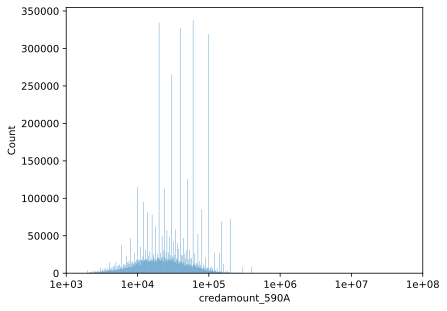

In [ ]:
ax = sns.histplot(np.log10(df_applprev_1_analysis['credamount_590A']))
ax.set_xlim([3,8])
ax.set_xticks(range(3,9))
ax.set_xticklabels(['%.0e'%a for a in 10**ax.get_xticks()])

## 0. case_id
## 1. actualdpd_943P
Days Past Due (DPD) of previous contract (actual).
## 2. annuity_853A
Monthly annuity for previous applications.
## 3. approvaldate_319D
Approval Date of Previous Application
## 4. byoccupationinc_3656910L
Applicant's income from previous applications.

## 5. cancelreason_3545846M
Application cancellation reason.
## 6. childnum_21L
Number of children in the previous application.

## 7. creationdate_885D
Date when previous application was created.

## 8. credacc_actualbalance_314A
Actual balance on credit account.Current amount owed.

## 9. credacc_credlmt_575A
Credit card credit limit provided for previous applications.

## 10. credacc_maxhisbal_375A
Maximal historical balance of previous credit account. This attribute represents the maximum historical balance of the previous credit account. It reflects the highest debt balance reached at a certain point during the account's life. This value can be used to evaluate the borrower's maximum borrowing level when using credit, and then analyze its debt repayment ability and financial management habits.

## 11. credacc_minhisbal_90A
Minimum historical balance of previous credit accounts. This attribute represents the minimum historical balance of the previous credit account. This may refer to the lowest debt balance during the account's existence, or if the account has ever had a positive balance (such as a prepaid account), it may be the lowest positive balance. This information helps to understand the borrower's credit utilization pattern and minimum debt level, and has certain reference value for assessing its financial stability.

## 12. credacc_status_367L
Account status of previous credit applications.

## 13. credacc_transactions_402L
Number of transactions made with the previous credit account of the applicant.

## 14. credamount_590A
Loan amount or card limit of previous applications.

## 15. credtype_587L
Credit type of previous application.

## 16. currdebt_94A
Previous application's current debt.

## 17. dateactivated_425D
Contract activation date of the applicant's previous application.

## 18. district_544M
District of the address used in the previous loan application.

## 19. downpmt_134A
Previous application downpayment amount.

## 20. dtlastpmt_581D
Date of last payment made by the applicant.

## 21. dtlastpmtallstes_3545839D
Date of the applicant's last payment.

## 22. education_1138M
Applicant's education level from their previous application.

## 23. employedfrom_700D
Employment start date from the previous application.

## 24. familystate_726L
Family State in previous application of applicant.

## 25. firstnonzeroinstldate_307D
Date of first instalment in the previous application.

## 26. inittransactioncode_279L
Type of the initial transaction made in the previous application of the client.

## 27. isbidproduct_390L
Flag for determining if the product is a cross-sell in previous applications.

## 28. isdebitcard_527L
Previous application flag indicating if product being applied for is a debit card.

## 29. mainoccupationinc_437A
Client's main income amount in their previous application.

## 30. maxdpdtolerance_577P
Maximum DPD with tolerance (on previous application/s).
## 31. num_group1
not found
## 32. outstandingdebt_522A
Amount of outstanding debt on the client's previous application.
## 33. pmtnum_8L
Number of payments made for the previous application.
## 34. postype_4733339M
Type of point of sale.
## 35. profession_152M
Profession of the client during their previous loan application.
## 36. rejectreason_755M
Reason for previous application rejection.
## 37. rejectreasonclient_4145042M
Reason for rejection of the client's previous application.
## 38. revolvingaccount_394A
Revolving account that was present in the applicant's previous application.
## 39. status_219L
Previous application status.
## 40. tenor_203L
Number of instalments in the previous application.

# **applprev_2**

In [ ]:
df_applprev_2 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_applprev_2.csv')

In [ ]:
df_applprev_2.info()

In [ ]:
df_applprev_2.describe()

In [ ]:
des_iterator_applprev_2 = batch_descriptions(df_applprev_2,des_dict,10)

In [ ]:
iterator_output=next(des_iterator_applprev_2)
print(format_output(iterator_output,0))

## 0. case_id
not found
## 1. cacccardblochreas_147M
Card blocking reason.
## 2. conts_type_509L
Person contact type in previous application.
## 3. credacc_cards_status_52L
Card status of the previous credit account.
## 4. num_group1
not found
## 5. num_group2
not found

# **tax_registry_a_1**

In [ ]:
df_tax_registry_a_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_tax_registry_a_1.csv')

In [ ]:
df_tax_registry_a_1.info()

In [ ]:
df_tax_registry_a_1.describe()

In [ ]:
des_tax_registry_a_1 = batch_descriptions(df_tax_registry_a_1,des_dict,10)

In [ ]:
iterator_output=next(des_tax_registry_a_1)
print(format_output(iterator_output,0))

## 0. case_id
not found
## 1. amount_4527230A
Tax deductions amount tracked by the government registry.
## 2. name_4527232M
Name of employer.
## 3. num_group1
not found
## 4. recorddate_4527225D
Date of tax deduction record.

# **credit_bureau_a_1_0**

## **Bussiness analysis**

### **Credit behavior and repayment ability**
**16. debtoverdue_47A**: The overdue amount of the customer's existing credit contract directly reflects the repayment ability.

**18. dpdmax_139P & 19. dpdmax_757P**: The maximum number of overdue days for active contracts and closed contracts. The number of overdue days is a key indicator for measuring credit risk.

**31. monthlyinstlamount_332A & 32. monthlyinstlamount_674A**: The monthly payment amount of active contracts and closed contracts. The monthly payment amount reflects the borrower's affordability.

**42. numberofoverdueinstlmax_1039L & 43. numberofoverdueinstlmax_1151L**: The maximum number of overdue installments for active contracts and closed contracts. The number of overdue installments provides details of repayment behavior.

**51. overdueamount_659A & 50. overdueamount_31A**: The overdue amount of active contracts and closed contracts. The overdue amount is a direct indicator of credit risk.

**52. overdueamountmax2_14A & 53. overdueamountmax2_398A**: The maximum overdue amount of active contracts and closed contracts. The maximum overdue amount shows the worst repayment situation.

**75. totaldebtoverduevalue_178A & 76. totaldebtoverduevalue_718A**: The total overdue debt amount of active contracts and closed contracts. The total overdue debt amount reflects the overall overdue status of the borrower.

### **Credit history**
**7. contractsum_5085717L**: The total value of other contracts, which may reflect the borrower's level of credit activity.

**36. numberofcontrsvalue_258L & 37. numberofcontrsvalue_358L**: The number of active contracts and closed contracts in the credit bureau. The number of contracts can reflect the borrower's credit experience.

**38. numberofinstls_229L & 39. numberofinstls_320L**: The number of installments for closed and active contracts. The number of installments provides details of the borrower's repayment plan.

**48. outstandingamount_354A & 49. outstandingamount_362A**: The outstanding amount of closed credit contracts and active contracts. The outstanding amount reflects the current debt level.

**77. totaloutstanddebtvalue_39A & 78. totaloutstanddebtvalue_668A**: Total outstanding debt for active and closed contracts in the credit bureau. Total outstanding debt provides an overall view of a borrower's liabilities.

### **Contract characteristics**
**1. annualeffectiverate_199L & 2. annualeffectiverate_63L**: The annual effective interest rate of closed contracts and active contracts. The interest rate level can affect the repayment burden.

**3. classificationofcontr_13M & 4. classificationofcontr_400M**: Classification of active contracts and closed contracts. Contract classification may affect default risk assessment.

**5. contractst_545M & 6. contractst_964M**: Contract status, including the status of terminated credit contracts, the contract status can reflect the current status of the credit contract.

### **Financial Information**
**8. credlmt_230A & 9. credlmt_935A**: The credit limit of closed credit contracts and active loans. The credit limit reflects the credit capacity of the borrower.

**15. debtoutstand_525A**: The outstanding amount of existing contracts, providing a view of the borrower's current liabilities.



In [ ]:
df_credit_bureau_a_1_0 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_credit_bureau_a_1_0.csv')

In [ ]:
df_credit_bureau_a_1_0.info()

In [ ]:
df_credit_bureau_a_1_0.describe()

In [ ]:
des_credit_bureau_a_1_0 = batch_descriptions(df_credit_bureau_a_1_0,des_dict,10)

In [ ]:
iterator_output=next(des_credit_bureau_a_1_0)
print(format_output(iterator_output,70))

## 0. case_id
not found
## 1. annualeffectiverate_199L
Interest rate of the closed contracts.
## 2. annualeffectiverate_63L
Interest rate for the active contracts.
## 3. classificationofcontr_13M
Classificiation of the active contract.
## 4. classificationofcontr_400M
Classificiation of the closed contract.
## 5. contractst_545M
Contract status.
## 6. contractst_964M
Contract status of terminated credit contract.
## 7. contractsum_5085717L
Sum of other contract values.
## 8. credlmt_230A
Credit limit of the closed credit contracts from credit bureau.
## 9. credlmt_935A
Credit limit for active loan.

## 10. dateofcredend_289D
End date of an active credit contract.
## 11. dateofcredend_353D
End date of a closed credit contract.
## 12. dateofcredstart_181D
Date when the credit contract was closed.
## 13. dateofcredstart_739D
Start date of a closed credit contract.
## 14. dateofrealrepmt_138D
Date of credit's closure (contract termination date).
## 15. debtoutstand_525A
Outstanding amount of existing contract.
## 16. debtoverdue_47A
Amount that is currently past due on a client's existing credit contract.
## 17. description_351M
Categorization of clients by credit bureau.
## 18. dpdmax_139P
Maximal days past due for active contract.
## 19. dpdmax_757P
Maximum days past due for a closed contract.

## 20. dpdmaxdatemonth_442T
Max DPD occurrence month for terminated contracts from credit bureau data.
## 21. dpdmaxdatemonth_89T
Month when maximum days past due occurred on the active contract with the credit bureau.
## 22. dpdmaxdateyear_596T
Year when maximum Days Past Due (DPD) occurred for the active contract.
## 23. dpdmaxdateyear_896T
Year of maximum Days Past Due of closed contract obtained from Credit Bureau.
## 24. financialinstitution_382M
Name of financial institution that is linked to a closed contract.
## 25. financialinstitution_591M
Financial institution name of the active contract.
## 26. instlamount_768A
Instalment amount for the active contract in credit bureau.
## 27. instlamount_852A
Instalment amount for closed contract.
## 28. interestrate_508L
Interest rate for a closed contract in the credit bureau.
## 29. lastupdate_1112D
Date of last update for an active contract from credit bureau.

## 30. lastupdate_388D
Date of last update for a closed contract in the credit bureau.
## 31. monthlyinstlamount_332A
Monthly instalment amount for active contract.
## 32. monthlyinstlamount_674A
Monthly amount of instalment payment on a closed contract.
## 33. nominalrate_281L
Interest rate of the active contract.
## 34. nominalrate_498L
Interest rate for closed contract.
## 35. num_group1
not found
## 36. numberofcontrsvalue_258L
Number of active contracts in credit bureau.
## 37. numberofcontrsvalue_358L
Number of closed credit contracts.
## 38. numberofinstls_229L
Number of instalments on closed contract.
## 39. numberofinstls_320L
Number of instalments of the active contract.

## 40. numberofoutstandinstls_520L
Number of outstanding instalment for closed contract.
## 41. numberofoutstandinstls_59L
Number of outstanding instalments for the active contracts.
## 42. numberofoverdueinstlmax_1039L
Number of outstanding instalments for active contracts.
## 43. numberofoverdueinstlmax_1151L
Maximum number of past due installments for a closed contract.
## 44. numberofoverdueinstlmaxdat_148D
Date of maximum number of past due instalments for the closed contract.
## 45. numberofoverdueinstlmaxdat_641D
Date of maximum number of past due instalments for the active contract.
## 46. numberofoverdueinstls_725L
Maximum number of past due instalments for an active contract.
## 47. numberofoverdueinstls_834L
Number of past due instalments for a closed contract.
## 48. outstandingamount_354A
Outstanding amount for closed credit contract in credit bureau.
## 49. outstandingamount_362A
Active contract's outstanding amount.

## 50. overdueamount_31A
Past due amount for a closed contract.
## 51. overdueamount_659A
Past due amount for active contract.
## 52. overdueamountmax2_14A
Maximal past due amount for an active contract.
## 53. overdueamountmax2_398A
Maximal overdue amount for a closed contract.
## 54. overdueamountmax2date_1002D
Date of maximal past due amount for a closed contract
## 55. overdueamountmax2date_1142D
Date of maximal past due amount for an active contract.
## 56. overdueamountmax_155A
Maximal past due amount for active contract.
## 57. overdueamountmax_35A
Maximal past due amount for a closed contract.
## 58. overdueamountmaxdatemonth_284T
Month when the maximum past due amount occurred for a closed contract.
## 59. overdueamountmaxdatemonth_365T
Month when maximum past due amount occurred for an active contract.

## 60. overdueamountmaxdateyear_2T
Year when the maximum past due amount occurred for active contracts.
## 61. overdueamountmaxdateyear_994T
Year when maximum past due amount occurred for closed contract.
## 62. periodicityofpmts_1102L
Frequency of instalments for a closed contract.
## 63. periodicityofpmts_837L
Frequency of instalments for an active contract.
## 64. prolongationcount_1120L
Count of prolongations on terminated contract according to credit bureau.
## 65. prolongationcount_599L
Count of active contract prolongations.
## 66. purposeofcred_426M
Purpose of credit for active contract.
## 67. purposeofcred_874M
Purpose of credit on a closed contract.
## 68. refreshdate_3813885D
Date when the credit bureau's public sources have been last updated.
## 69. residualamount_488A
Residual amount of a closed contract.

## 70. residualamount_856A
Residual amount for the active contract.
## 71. subjectrole_182M
Subject role in active credit contract.
## 72. subjectrole_93M
Subject role in closed credit contract.
## 73. totalamount_6A
Total amount of closed contracts.
## 74. totalamount_996A
Total amount of active contracts in the credit bureau.
## 75. totaldebtoverduevalue_178A
Total amount of past due debt on active contracts.
## 76. totaldebtoverduevalue_718A
Total overdue debt amount for closed credit contracts.
## 77. totaloutstanddebtvalue_39A
Total outstanding debt for active contracts in the credit bureau.
## 78. totaloutstanddebtvalue_668A
Total outstanding debt for the closed contracts in the credit bureau.

# **credit_bureau_a_2_0**
## **Bussiness analysis**
### **Collateral or collateral information**
**1. collater_typofvalofguarant_298M & 2. collater_typofvalofguarant_407M**: Collateral valuation type for active and closed contracts, providing information on the collateral valuation method.

**3. collater_valueofguarantee_1124L & 4. collater_valueofguarantee_876L**: The collateral value of active contracts and closed contracts directly reflects the security and potential recovery value of the loan.

**5. collaterals_typeofguarante_359M & 6. collaterals_typeofguarante_669M**: The type of collateral used as guarantee for closed contracts and active contracts. The type of collateral can affect the recovery of losses after default.
### **Payment history**
**9. pmts_dpd_1073P & 10. pmts_dpd_303P**: The number of days payment is overdue for active contracts and terminated contracts. The number of days overdue is a key indicator for measuring credit risk.

**11. pmts_month_158T & 12. pmts_month_706T**: Payment month for closed contracts and active contracts. Payment timing can help analyze the applicant's repayment pattern and seasonal effects.

**13. pmts_overdue_1140A & 14. pmts_overdue_1152A**: The overdue payment amount of active contracts and closed contracts. The overdue amount provides direct evidence of default risk.

**15. pmts_year_1139T & 16. pmts_year_507T**: The payment year of active contracts and closed credit contracts. Knowing the payment year helps analyze the applicant's long-term repayment behavior.
### **Contract role information**
**17. subjectroles_name_541M & 18. subjectroles_name_838M**: The name of the subject role in the closed credit contract and the active credit contract. The subject role can reveal the applicant's responsibility and status in the contract.

In [ ]:
df_credit_bureau_a_2_0 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_credit_bureau_a_2_0.csv')

In [ ]:
df_credit_bureau_a_2_0.info()

In [ ]:
df_credit_bureau_a_2_0.describe()

In [ ]:
des_credit_bureau_a_2_0 = batch_descriptions(df_credit_bureau_a_2_0,des_dict,10)

In [ ]:
iterator_output=next(des_credit_bureau_a_2_0)
print(format_output(iterator_output,10))

## 0. case_id
not found
## 1. collater_typofvalofguarant_298M
Collateral valuation type (active contract).
## 2. collater_typofvalofguarant_407M
Collateral valuation type (closed contract).
## 3. collater_valueofguarantee_1124L
Value of collateral for active contract.
## 4. collater_valueofguarantee_876L
Value of collateral for closed contract.
## 5. collaterals_typeofguarante_359M
Type of collateral that was used as a guarantee for a closed contract.
## 6. collaterals_typeofguarante_669M
Collateral type for the active contract.
## 7. num_group1
not found
## 8. num_group2
not found
## 9. pmts_dpd_1073P
Days past due of the payment for the active contract (num_group1 - existing contract, num_group2 - payment).

## 10. pmts_dpd_303P
Days past due of the payment for terminated contract according to credit bureau (num_group1 - terminated contract, num_group2 - payment).
## 11. pmts_month_158T
Month of payment for a closed contract (num_group1 - existing contract, num_group2 - payment).
## 12. pmts_month_706T
Month of payment for active contract (num_group1 - terminated contract, num_group2 - payment).
## 13. pmts_overdue_1140A
Overdue payment for an active contract (num_group1 - existing contract, num_group2 - payment).
## 14. pmts_overdue_1152A
Overdue payment for a closed contract (num_group1 - terminated contract, num_group2 - payment).
## 15. pmts_year_1139T
Year of payment for an active contract (num_group1 - existing contract, num_group2 - payment).
## 16. pmts_year_507T
Payment year for a closed credit contract (num_group1 - terminated contract, num_group2 - payment).
## 17. subjectroles_name_541M
Name of subject role in closed credit contract (num_group1 - terminated contract, num_group2 - subject roles).
## 18. subjectroles_name_838M
Name of subject role in active credit contract (num_group1 - existing contract, num_group2 - subject roles).

# **credit_bureau_b_1**
## **Bussiness analysis**
### **Credit behavior and repayment ability**
**1. amount_1115A**: Credit amount of the active contract provided by the credit bureau.

**7. credlmt_1052A, 8. credlmt_228A, 9. credlmt_3940954A**: Credit limits for active and closed loans.

**13. debtpastduevalue_732A**: Amount of unpaid debt for existing contracts.

**14. debtvalue_227A**: Outstanding amount for existing debt contracts.

**15. dpd_550P, 16. dpd_733P, 17. dpdmax_851P**: Days past due for active and closed contracts.

**21. installmentamount_833A, 22. installmentamount_892A**: Installment amounts for active credit contracts.
### **credit history**
**11. credquantity_1099L, 12. credquantity_984L**: Number of credits in credit bureau.
### **Contract characteristics**
**2. classificationofcontr_1114M**: Classification of the active contract.

**5. contractst_516M**: Contract status.

**6. contracttype_653M**: Contract Type.

**37. purposeofcred_722M**: Purpose of credit for active contracts.

In [ ]:
df_credit_bureau_b_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_credit_bureau_b_1.csv')

In [ ]:
df_credit_bureau_b_1.info()

In [ ]:
df_credit_bureau_b_1.describe()

In [ ]:
des_credit_bureau_b_1 = batch_descriptions(df_credit_bureau_b_1,des_dict,10)

In [ ]:
iterator_output=next(des_credit_bureau_b_1)
print(format_output(iterator_output,40))


## 0. case_id
not found
## 1. amount_1115A
Credit amount of the active contract provided by the credit bureau.
## 2. classificationofcontr_1114M
Classificiation of the active contract.
## 3. contractdate_551D
Contract date of the active contract
## 4. contractmaturitydate_151D
End date of active contract.
## 5. contractst_516M
Contract status.
## 6. contracttype_653M
Contract Type
## 7. credlmt_1052A
Credit limit of an active loan.
## 8. credlmt_228A
Credit limit for closed loans.
## 9. credlmt_3940954A
Credit limit for active loan.


## 10. credor_3940957M
Creditor's name
## 11. credquantity_1099L
Number of credits in credit bureau
## 12. credquantity_984L
Number of closed credits in credit bureau.
## 13. debtpastduevalue_732A
Amount of unpaid debt for existing contracts.
## 14. debtvalue_227A
Outstanding amount for existing debt contracts.
## 15. dpd_550P
The number of days past due for active loans where a guarantee has been provided.
## 16. dpd_733P
Days past due (DPD) for guaranteed loans that were terminated according to credit bureau data.
## 17. dpdmax_851P
Maximal past due days for active contracts in the credit bureau.
## 18. dpdmaxdatemonth_804T
Month when the maximum Day Past Due (DPD) occurred for active contracts on credit bureau's records.
## 19. dpdmaxdateyear_742T
Year of the maximum Days Past Due (DPD) on an active credit contract in the credit bureau.

## 20. installmentamount_644A
Instalment amount of a closed and secured credit contract.
## 21. installmentamount_833A
Instalment amount for a secured and active contract in credit bureau.
## 22. instlamount_892A
Instalment amount for active credit contract.
## 23. interesteffectiverate_369L
Interest rate on active contract.
## 24. interestrateyearly_538L
Annual interest rate for existing contract obtained from credit bureau.
## 25. lastupdate_260D
Last update date for the active contracts.
## 26. maxdebtpduevalodued_3940955A
Days past due at the time of the maximum debt.
## 27. num_group1
not found
## 28. numberofinstls_810L
Number of instalments for the active contract.
## 29. overdueamountmax_950A
Maximal past due amount for active contract.

## 30. overdueamountmaxdatemonth_494T
Month when the maximum past due amount was recorded for an active contract with the credit bureau.
## 31. overdueamountmaxdateyear_432T
Year when max past due amount occurred for active contract.
## 32. periodicityofpmts_997L
Frequency of instalments for active credit contracts.
## 33. periodicityofpmts_997M
Frequency of instalments for active credit contracts.
## 34. pmtdaysoverdue_1135P
Number of days past due for existing contracts in the credit bureau.
## 35. pmtmethod_731M
Instalment payment method for existing contract in credit bureau.
## 36. pmtnumpending_403L
Number of pending payments for active contract.
## 37. purposeofcred_722M
Purpose of credit for active contracts.
## 38. residualamount_1093A
Residual amount of closed guarantee contract.
## 39. residualamount_127A
Residual amount of active guarantee contract.

## 40. residualamount_3940956A
Residual amount for the active contract.
## 41. subjectrole_326M
Subject role in active credit contract.
## 42. subjectrole_43M
Subject role in closed credit contract.
## 43. totalamount_503A
Total amount of active secured credit for a client.
## 44. totalamount_881A
Total amount of secured credit from closed contracts.

# **deposit_1**


In [ ]:
df_deposit_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_deposit_1.csv')

In [ ]:
df_deposit_1.info()

# **person_1**

In [ ]:
df_person_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_person_1.csv')

In [ ]:
df_person_1.info()

In [ ]:
df_person_1.describe()

In [ ]:
des_person_1 = batch_descriptions(df_person_1,des_dict,10)

In [ ]:
iterator_output=next(des_person_1)
print(format_output(iterator_output,30))

## 0. case_id
not found
## 1. birth_259D
Date of birth of the person.
## 2. birthdate_87D
Birth date of the person.
## 3. childnum_185L
Number of children of the applicant.
## 4. contaddr_district_15M
Zip code of a contact person's address.
## 5. contaddr_matchlist_1032L
Indicates whether the contact address is found in a code list.
## 6. contaddr_smempladdr_334L
Indicates whether the contact address is the same as the employment address.
## 7. contaddr_zipcode_807M
Zip code of contact address.
## 8. education_927M
Education level of the person.
## 9. empl_employedfrom_271D
Start date of employment.

## 10. empl_employedtotal_800L
Employment length of a person.
## 11. empl_industry_691L
Employment Industry of the person.
## 12. empladdr_district_926M
District where the employer's address is located.
## 13. empladdr_zipcode_114M
Zipcode of employer's address.
## 14. familystate_447L
Family state of the person.
## 15. gender_992L
Gender of a person.
## 16. housetype_905L
House type of the person.
## 17. housingtype_772L
Type of housing of the person.
## 18. incometype_1044T
Type of income of the person
## 19. isreference_387L
Flag indicating whether the person is a reference contact.

## 20. language1_981M
The primary language of the person.
## 21. mainoccupationinc_384A
Amount of the main income of the client.
## 22. maritalst_703L
Marital status of the client.
## 23. num_group1
not found
## 24. personindex_1023L
Order of the person specified on the application form.
## 25. persontype_1072L
Person type.
## 26. persontype_792L
Person type.
## 27. registaddr_district_1083M
District of person's registered address.
## 28. registaddr_zipcode_184M
Registered address's zip code of a person.
## 29. relationshiptoclient_415T
Relationship to the client.

## 30. relationshiptoclient_642T
Relationship to the client.
## 31. remitter_829L
Flag indicating whether the client is a remitter.
## 32. role_1084L
Type of contact role.
## 33. role_993L
Person's role.
## 34. safeguarantyflag_411L
Flag indicating if client is using a flexible product with additional safeguard garanty.
## 35. sex_738L
Gender of the client.
## 36. type_25L
Contact type of a person.

# **person_2**

In [ ]:
df_person_2 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_person_2.csv')

In [ ]:
df_person_2.info()

# **debitcard_1**

In [ ]:
df_debitcard_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_debitcard_1.csv')

In [ ]:
df_debitcard_1.info()

# **other_1**

In [ ]:
df_other_1 = load_and_process_csv('/content/home-credit-data/csv_files/train/train_other_1.csv')

In [ ]:
df_other_1.info()